## NETWORK DESCRIPTION

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
from community import community_louvain
import seaborn as sns


# **Data**

In [2]:
data=pd.read_json('network_data.json')
data.head()

,comment_depth,interacts_with_depth,text_son,text_mother,son_date,mother_date,upvotes_son,upvotes_mother,author_son,author_mother
0,1,0,Same as it’s always been; entirely within reac...,Either for a two-state solution or a one-state...,2023-07-01,2023-07-01,34,15,KosherPigBalls,u/ANobodyBoy
1,2,1,beautifully said,Same as it’s always been; entirely within reac...,2023-07-01,2023-07-01,6,34,GrazingGeese,KosherPigBalls
2,2,1,Slightly more realistic than OP's username,Same as it’s always been; entirely within reac...,2023-07-02,2023-07-01,3,34,NumenSD,KosherPigBalls
3,2,1,Is this Schrödinger's peace cat ?,Same as it’s always been; entirely within reac...,2023-07-02,2023-07-01,1,34,Hsbsbhgdgdu,KosherPigBalls
4,1,0,We're more likely be heading to an escalation ...,Either for a two-state solution or a one-state...,2023-07-02,2023-07-01,5,15,Shachar2like,u/ANobodyBoy


# **Functions**

### Function to Filter our dataset + function to define top authors (based on the number of comments and posts)

In [29]:
def filtered_dataset(data, start_date, end_date):

    filtro = (data['son_date'] >= start_date) & (data['son_date'] <= end_date) & (data['mother_date'] >= start_date) & (data['mother_date'] <= end_date)
    filtered_data = data[filtro]
    filtered_data = filtered_data.dropna(subset=['author_son', 'author_mother'])
    return filtered_data

In [4]:
def define_top_authors(filtered_data, n):
    list_author_son = filtered_data.groupby("author_son")["text_son"].count().reset_index().sort_values("text_son",ascending = False).head(n).author_son.tolist()
    list_author_mother = filtered_data.groupby("author_mother")["text_mother"].count().reset_index().sort_values("text_mother",ascending = False).head(n).author_mother.tolist()
    top_authors = set(list_author_son + list_author_mother)

    return top_authors

In [5]:
def top_authors_over_periods(data, periods, top_n=1000, query="interacts_with_depth == 0"):
    results = []

    for i, (start_date, end_date) in enumerate(periods):
        filtered_data = filtered_dataset(data, start_date, end_date, query)
        top_authors = define_top_authors(filtered_data, top_n)
        network = i + 1 
        for author in top_authors:
            results.append({
                'author': author,
                'start_date': start_date,
                'end_date': end_date,
                'network': network
            })

    
    top_authors_df = pd.DataFrame(results)
    
    repeats = top_authors_df['author'].value_counts().reset_index()
    repeats.columns = ['author', 'number_of_times_top_author']

    return top_authors_df, repeats


### function to generate a graph and plot it 

In [92]:
def graph_creation(filtered_data):
    G = nx.Graph()
    for index, row in filtered_data.iterrows():
        son = row['author_son']
        mother = row['author_mother']
        if G.has_edge(son, mother):
            G[son][mother]['weight'] += 1
        else:
            G.add_edge(son, mother, weight=1)
    return G


In [10]:
def plot_graph(G, start_date, end_date):
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G, k=0.1)
    edges = G.edges(data=True)
    weights = [edge[2]['weight'] for edge in edges]

    nx.draw_networkx_nodes(G, pos, node_size=50)
    nx.draw_networkx_edges(G, pos, edgelist=edges, width=weights, alpha=0.5)
    nx.draw_networkx_labels(G, pos, font_size=8)

    plt.title(f'Network of Interactions from {start_date} to {end_date}')
    plt.show()

In [14]:
def remove_nodes_above_threshold(graph, threshold):
    edges_to_remove = [(u, v) for u, v, d in graph.edges(data=True) if d['weight'] > threshold]
    for edge in edges_to_remove:
        graph.remove_edge(*edge)

    graph.remove_nodes_from(list(nx.isolates(graph)))

    return graph

### Function to define network centralities

In [74]:
def calculate_centralities(graph):
    degree_centrality = nx.degree_centrality(graph)
    betweenness_centrality = nx.betweenness_centrality(graph)
    closeness_centrality = nx.closeness_centrality(graph)
    
    return degree_centrality, betweenness_centrality, closeness_centrality

#### function to measure the network centralities of the authors over time

In [75]:
def calculate_centrality_over_time(filtered_data, top_authors):
    centrality_measures = {author: {} for author in top_authors}

    G = graph_creation(filtered_data)

    degree_centrality = nx.degree_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)


    for author in top_authors:
        author_degree_centrality = degree_centrality.get(author, 0)
        author_closeness_centrality = closeness_centrality.get(author, 0)
        author_betweenness_centrality = betweenness_centrality.get(author, 0)


        centrality_measures[author]['Degree'] = author_degree_centrality
        centrality_measures[author]['Closeness'] = author_closeness_centrality
        centrality_measures[author]['Betweenness'] = author_betweenness_centrality


    df = pd.DataFrame.from_dict(centrality_measures, orient='index')
    return df


In [104]:
def generate_combined_centralities(data, periods, top_n=100, query="interacts_with_depth == 0"):
    combined_centralities = []

    for i, (start_date, end_date) in enumerate(periods):
        filtered_data = filtered_dataset(data, start_date, end_date, query)
        top_authors = define_top_authors(filtered_data, top_n)
        G = graph_creation(filtered_data)
        subgraph = G.subgraph(top_authors)
        network= i+1
        
        degree_centrality, betweenness_centrality, closeness_centrality = calculate_centralities(subgraph)

        for author in top_authors:
            combined_centralities.append({
                'author': author,
                'start_date': start_date,
                'end_date': end_date,
                'network': network,
                'degree_centrality': degree_centrality.get(author, 0),
                'betweenness_centrality': betweenness_centrality.get(author, 0),
                'closeness_centrality': closeness_centrality.get(author, 0),
            })

    combined_df = pd.DataFrame(combined_centralities)
    return combined_df

In [73]:
def plot_top_authors_centrality(centrality_measures, num_authors=100):
    plt.figure(figsize=(14, 10))
    sorted_authors = sorted(centrality_measures.keys(), key=lambda author: -sum(measure[1] for measure in centrality_measures[author]))
    top_authors = sorted_authors[:num_authors]

    for i, centrality_type in enumerate(['Degree', 'Closeness', 'Betweenness'], start=1):
        plt.subplot(2, 2, i)

        for author in top_authors:
            measures = centrality_measures[author]
            dates, degree, closeness, betweenness, eigenvector = zip(*measures)
            centrality_values = {'Degree': degree, 'Closeness': closeness, 'Betweenness': betweenness}
            
            plt.plot(dates, centrality_values[centrality_type], label=author)

        plt.title(f'{centrality_type} Centrality Over Time')
        plt.xlabel('Time')
        plt.ylabel(f'{centrality_type} Centrality')


    plt.tight_layout()
    plt.show()

### Function to describe the network of a graph

In [114]:
def description_of_network(G):
    descrizione = {}


    descrizione['average_degree'] = sum(dict(G.degree()).values()) / len(G)
    descrizione['density'] = nx.density(G)
    descrizione['average_clustering'] = nx.average_clustering(G)
 

    if nx.is_connected(G):
        descrizione['average_path_length'] = nx.average_shortest_path_length(G)
        descrizione['diameter'] = nx.diameter(G)
    else:
        descrizione['average_path_length'] = None
        descrizione['diameter'] = None


    df = pd.DataFrame(descrizione, index=[0])
    
    return df


In [34]:
def generate_network_descriptions(data, periods, top_n=1000, query="interacts_with_depth == 0"):
    all_descriptions = pd.DataFrame()

    for i, (start_date, end_date) in enumerate(periods):
        filtered_data = filtered_dataset(data, start_date, end_date, query)
        top_authors = define_top_authors(filtered_data, top_n)
        G = graph_creation(filtered_data)
        subgraph = G.subgraph(top_authors)
        description = description_of_network(subgraph)
        description.index = [f'network_{i+1}']
        all_descriptions = pd.concat([all_descriptions, description])

    return all_descriptions

In [117]:
def plot_network_descriptions(descriptions):
    descriptions = descriptions.reset_index().rename(columns={'index': 'network'})
    descriptions['network'] = descriptions['network'].apply(lambda x: int(x.split('_')[1]))
    metrics = ['average_degree', 'density', 'average_clustering', 'average_path_length', 'diameter']

    fig, axs = plt.subplots(len(metrics), 1, figsize=(12, 18), constrained_layout=True)
    fig.suptitle('Network Metrics Over Time', fontsize=16, fontweight='bold', y=1.02)
    for ax, metric in zip(axs, metrics):
        ax.plot(descriptions['network'], descriptions[metric], marker='o', linestyle='-', linewidth=2, markersize=6)
        ax.set_title(f'{metric.replace("_", " ").capitalize()} Over Time', fontsize=14, fontweight='bold')
        ax.set_xlabel('Network', fontsize=12)
        ax.set_ylabel(metric.replace("_", " ").capitalize(), fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.tick_params(axis='both', which='major', labelsize=10)
        
    plt.subplots_adjust(hspace=0.5)
    

    plt.show()

In [ ]:
from pyvis.network import Network
import networkx as nx
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def create_interactive_network(graph, output_file_name="interactive_network.html"):
    # Create the pyvis network
    net = Network(notebook=True, cdn_resources='in_line')

    # Load the NetworkX graph
    net.from_nx(graph)

    # Calculate centrality measures
    betweenness_centrality = nx.betweenness_centrality(graph)
    degree_centrality = nx.degree_centrality(graph)

    # Normalize the centrality measures to [0, 1]
    betweenness_norm = mcolors.Normalize(vmin=min(betweenness_centrality.values()), vmax=max(betweenness_centrality.values()))
    degree_norm = mcolors.Normalize(vmin=min(degree_centrality.values()), vmax=max(degree_centrality.values()))

    # Get the plasma colormap for nodes
    plasma_cmap = cm.get_cmap('plasma')

    # Update node properties based on centrality measures
    for node in net.nodes:
        node_id = node['id']
        node['size'] = degree_centrality[node_id] * 450  # Adjust size as needed
        node['font'] = {'size': degree_centrality[node_id]* 350 + 10}
        color = plasma_cmap(betweenness_norm(betweenness_centrality[node_id]))
        node['color'] = mcolors.to_hex(color, keep_alpha=True)

    # Update edge properties based on weights, assigning a default weight if missing
    for edge in net.edges:
        weight = graph.edges[edge['from'], edge['to']].get('weight', 1)  # Default weight is 1 if 'weight' is missing
        edge['width'] = weight * 2  # Adjust width as needed
        edge['color'] = 'rgba(128, 128, 128, 0.6)'  # Use a fixed gray color for edges

    # Customize options for better visualization
    net.set_options("""
    var options = {
      "nodes": {
        "borderWidth": 2,
        "borderWidthSelected": 4,
        "color": {
          "highlight": {
            "border": "rgba(0,0,0,1)",
            "background": "rgba(255,255,255,1)"
          }
        },
        "font": {
          "color": "rgba(0,0,0,1)"
        }
      },
      "edges": {
        "color": {
          "inherit": false
        },
        "smooth": {
          "enabled": true,
          "type": "dynamic"
        }
      },
      "interaction": {
        "hover": true,
        "navigationButtons": true
      },
      "physics": {
        "enabled": true,
        "barnesHut": {
          "gravitationalConstant": -80000,
          "centralGravity": 0.3,
          "springLength": 250,
          "springConstant": 0.04,
          "damping": 0.09
        },
        "minVelocity": 0.75
      },
      "layout": {
        "improvedLayout": true
      }
    }
    """)

    # Show the interactive network
    net.show(output_file_name)

# Analysis

In [56]:
periods = [
    ('2023-08-07', '2023-09-06'),
    ('2023-09-07', '2023-10-06'),
    ('2023-10-07', '2023-11-06'),
    ('2023-11-07', '2023-12-06'),
    ('2023-12-07', '2024-01-06'),
    ('2024-01-07', '2024-02-06'),
    ('2024-02-07', '2024-03-06'),
    ('2024-03-07', '2024-04-06')
]


In [95]:
top_authors_df, top_authors_repeat= top_authors_over_periods(data, periods, top_n=100, query="interacts_with_depth == 0")

In [96]:
top_authors_df

,author,start_date,end_date,network
0,No_Host_884,2023-08-07,2023-09-06,1
1,Joe-586,2023-08-07,2023-09-06,1
2,ApprehensiveRush5128,2023-08-07,2023-09-06,1
3,shushi77,2023-08-07,2023-09-06,1
4,u/BigH200026,2023-08-07,2023-09-06,1
...,...,...,...,...
1414,PostmodernMelon,2024-03-07,2024-04-06,8
1415,Lamplighteris9,2024-03-07,2024-04-06,8
1416,AlphoBudda,2024-03-07,2024-04-06,8
1417,Otherwise-Ad-4361,2024-03-07,2024-04-06,8


In [97]:
top_authors_repeat

,author,number_of_times_top_author
0,knign,8
1,c9joe,8
2,JeffB1517,8
3,CreativeRealmsMC,8
4,Darth_Jonathan,7
...,...,...
1003,u/Striking-Ad-8688,1
1004,avatarthelastreddit,1
1005,OCDC123,1
1006,Outrageous-Bed7707,1


In [98]:
top_authors_df.to_csv('top authors')

In [99]:
top_authors_repeat.to_csv('top authors repeat')

In [60]:
all_network_description= generate_network_descriptions(data, periods, top_n=100, query="interacts_with_depth == 0")

In [111]:
all_network_description

,average_degree,density,average_clustering,assortativity,average_path_length,diameter
network_1,6.634146,0.054378,0.055605,-0.446419,2.641610,5
network_2,6.500000,0.048148,0.049546,-0.328898,2.832244,5
network_3,14.295918,0.073312,0.082247,-0.055817,2.319990,4
network_4,19.041237,0.098659,0.095462,-0.058517,2.138881,4
network_5,16.567010,0.085839,0.069770,-0.064527,2.216869,4
network_6,14.031915,0.075037,0.084328,-0.048392,2.284162,4
network_7,14.000000,0.073298,0.058549,-0.080678,2.324171,4
network_8,13.193878,0.067661,0.053730,-0.060698,2.380220,4


In [112]:
all_network_description.to_csv('all_network_description')

/var/folders/1_/1hvyzx7d45ddbls__y4g9kch0000gn/T/ipykernel_7582/1404372033.py:16: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.5)


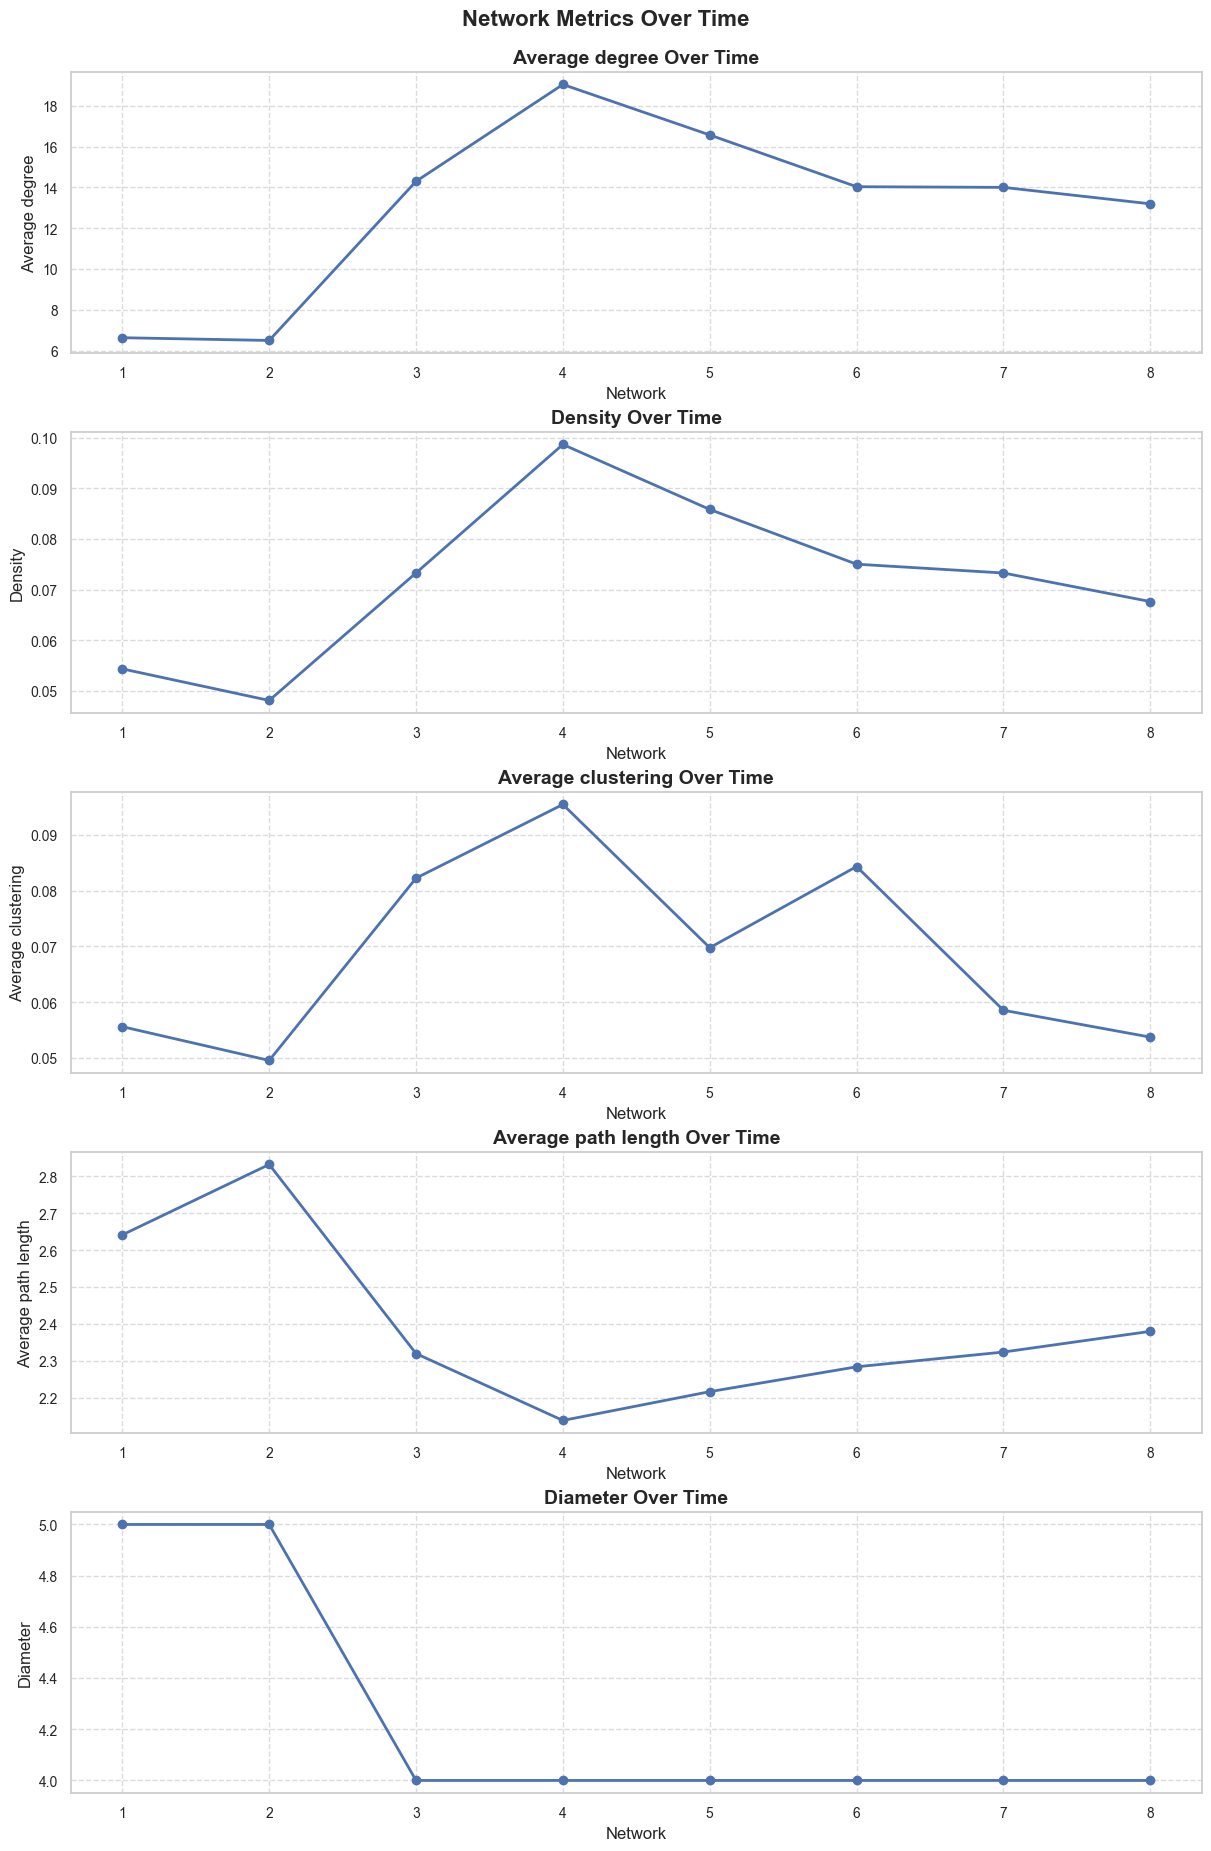

In [118]:
plot_network_descriptions(all_network_description)

In [105]:
all_centralities_df=generate_combined_centralities(data, periods)

In [169]:
all_centralities_df

,author,start_date,end_date,network,degree_centrality,betweenness_centrality,closeness_centrality
0,No_Host_884,2023-08-07,2023-09-06,1,0.131148,0.031841,0.400000
1,Joe-586,2023-08-07,2023-09-06,1,0.024590,0.001878,0.369697
2,ApprehensiveRush5128,2023-08-07,2023-09-06,1,0.172131,0.054349,0.413559
3,shushi77,2023-08-07,2023-09-06,1,0.016393,0.000537,0.333333
4,u/BigH200026,2023-08-07,2023-09-06,1,0.336066,0.178992,0.489960
...,...,...,...,...,...,...,...
1414,PostmodernMelon,2024-03-07,2024-04-06,8,0.123077,0.017357,0.498721
1415,Lamplighteris9,2024-03-07,2024-04-06,8,0.035897,0.001348,0.378641
1416,AlphoBudda,2024-03-07,2024-04-06,8,0.143590,0.022460,0.489950
1417,Otherwise-Ad-4361,2024-03-07,2024-04-06,8,0.076923,0.006122,0.424837


In [108]:
for i in range(1, len(periods) + 1):  
    network_df = all_centralities_df[all_centralities_df['network'] == i]
    filename = f'centrality_measures_network_{i}.csv'
    network_df.to_csv(filename, index=False)

In [132]:

top_authors_all_periods_list = top_authors_repeat[top_authors_repeat['number_of_times_top_author'] == 8]['author'].tolist()


filtered_data = all_centralities_df[all_centralities_df['author'].isin(top_authors_all_periods_list)]

pivoted_data = filtered_data.pivot_table(index='author', columns='network', values=['degree_centrality', 'betweenness_centrality', 'closeness_centrality'])


pivoted_data.to_csv('piv')


All periods

In [184]:

top_authors_multiple_periods = [
    'knign', 'c9joe', 'JeffB1517', 'CreativeRealmsMC',  # Top authors in all 8 periods
    'Darth_Jonathan', 'JosephL_55', 'Shachar2like',  # Top authors in 7 periods
    'Yakel1', 'pinchasthegris', 'AsleepFly2227'  # Top authors in 6 periods
]


filtered_df = all_centralities_df[all_centralities_df['author'].isin(top_authors_multiple_periods)]

average_degree_centrality = filtered_df['degree_centrality'].mean()
average_betweenness_centrality = filtered_df['betweenness_centrality'].mean()
average_closeness_centrality = filtered_df['closeness_centrality'].mean()

print(f"Average Degree Centrality: {average_degree_centrality}")
print(f"Average Betweenness Centrality: {average_betweenness_centrality}")
print(f"Average Closeness Centrality: {average_closeness_centrality}")




Average Degree Centrality: 0.09414232751398613
Average Betweenness Centrality: 0.014033511562075543
Average Closeness Centrality: 0.460831559036718


Period 4

In [162]:
start_date, end_date = periods[3]  
filtered_data_period_4 = filtered_dataset(data, start_date, end_date)
top_authors_period_4 = define_top_authors(filtered_data_period_4, 100)


G_period_4 = graph_creation(filtered_data_period_4)
G_period_4 = G_period_4.subgraph(top_authors_period_4)
create_interactive_network(G_period_4, "network_4_interactive.html")


network_4_interactive.html


/var/folders/1_/1hvyzx7d45ddbls__y4g9kch0000gn/T/ipykernel_7582/4175629423.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plasma_cmap = cm.get_cmap('plasma')


In [170]:
all_centralities_df[all_centralities_df['network'] == 4].sort_values(by='betweenness_centrality', ascending=False)


,author,start_date,end_date,network,degree_centrality,betweenness_centrality,closeness_centrality
509,Queasy_Ad_7297,2023-11-07,2023-12-06,4,0.305699,0.044351,0.584848
502,Yakel1,2023-11-07,2023-12-06,4,0.233161,0.034328,0.561047
529,habib-thebas,2023-11-07,2023-12-06,4,0.248705,0.031338,0.557803
485,Optimistbott,2023-11-07,2023-12-06,4,0.222798,0.029766,0.554598
638,rkd80,2023-11-07,2023-12-06,4,0.202073,0.025760,0.533149
...,...,...,...,...,...,...,...
637,u/Dangerous-Room4320,2023-11-07,2023-12-06,4,0.031088,0.000232,0.394683
597,Yeto25,2023-11-07,2023-12-06,4,0.020725,0.000071,0.392276
609,slenpeng,2023-11-07,2023-12-06,4,0.015544,0.000065,0.383698
498,0xBubbleMaker,2023-11-07,2023-12-06,4,0.025907,0.000041,0.378431


In [172]:
all_centralities_df[all_centralities_df['network'] == 4].sort_values(by='closeness_centrality', ascending=False)


,author,start_date,end_date,network,degree_centrality,betweenness_centrality,closeness_centrality
509,Queasy_Ad_7297,2023-11-07,2023-12-06,4,0.305699,0.044351,0.584848
502,Yakel1,2023-11-07,2023-12-06,4,0.233161,0.034328,0.561047
463,Special-Quantity-469,2023-11-07,2023-12-06,4,0.227979,0.023065,0.557803
529,habib-thebas,2023-11-07,2023-12-06,4,0.248705,0.031338,0.557803
485,Optimistbott,2023-11-07,2023-12-06,4,0.222798,0.029766,0.554598
...,...,...,...,...,...,...,...
560,oldstumper,2023-11-07,2023-12-06,4,0.031088,0.000419,0.387550
609,slenpeng,2023-11-07,2023-12-06,4,0.015544,0.000065,0.383698
559,Goodmooood,2023-11-07,2023-12-06,4,0.025907,0.000329,0.381423
498,0xBubbleMaker,2023-11-07,2023-12-06,4,0.025907,0.000041,0.378431


In [173]:
all_centralities_df[all_centralities_df['network'] == 4].sort_values(by='degree_centrality', ascending=False)


,author,start_date,end_date,network,degree_centrality,betweenness_centrality,closeness_centrality
509,Queasy_Ad_7297,2023-11-07,2023-12-06,4,0.305699,0.044351,0.584848
529,habib-thebas,2023-11-07,2023-12-06,4,0.248705,0.031338,0.557803
535,EducatorRelevant885,2023-11-07,2023-12-06,4,0.243523,0.025544,0.539106
502,Yakel1,2023-11-07,2023-12-06,4,0.233161,0.034328,0.561047
463,Special-Quantity-469,2023-11-07,2023-12-06,4,0.227979,0.023065,0.557803
...,...,...,...,...,...,...,...
577,IsraelPalestine-ModTeam,2023-11-07,2023-12-06,4,0.025907,0.000243,0.410638
498,0xBubbleMaker,2023-11-07,2023-12-06,4,0.025907,0.000041,0.378431
597,Yeto25,2023-11-07,2023-12-06,4,0.020725,0.000071,0.392276
609,slenpeng,2023-11-07,2023-12-06,4,0.015544,0.000065,0.383698


In [174]:
# List of authors who appeared as top authors in six or more periods
top_authors_multiple_periods = [
    'knign', 'c9joe', 'JeffB1517', 'CreativeRealmsMC',  # Top authors in all 8 periods
    'Darth_Jonathan', 'JosephL_55', 'Shachar2like',  # Top authors in 7 periods
    'Yakel1', 'pinchasthegris', 'AsleepFly2227'  # Top authors in 6 periods
]


In [182]:
filtered_sorted_df = all_centralities_df[
    (all_centralities_df['author'].isin(top_authors_multiple_periods)) & 
    (all_centralities_df['network'] == 4)
].sort_values(by='closeness_centrality', ascending=False)

In [181]:
filtered_sorted_df

,author,start_date,end_date,network,degree_centrality,betweenness_centrality,closeness_centrality
502,Yakel1,2023-11-07,2023-12-06,4,0.233161,0.034328,0.561047
648,JeffB1517,2023-11-07,2023-12-06,4,0.165803,0.013329,0.531680
530,CreativeRealmsMC,2023-11-07,2023-12-06,4,0.155440,0.010636,0.518817
503,knign,2023-11-07,2023-12-06,4,0.139896,0.005959,0.516043
604,Darth_Jonathan,2023-11-07,2023-12-06,4,0.098446,0.005193,0.481297
644,pinchasthegris,2023-11-07,2023-12-06,4,0.082902,0.003424,0.463942
508,JosephL_55,2023-11-07,2023-12-06,4,0.098446,0.003158,0.488608
589,c9joe,2023-11-07,2023-12-06,4,0.072539,0.001820,0.463942
615,Shachar2like,2023-11-07,2023-12-06,4,0.051813,0.001066,0.447796
550,AsleepFly2227,2023-11-07,2023-12-06,4,0.041451,0.000845,0.416847


## CROSS-FACTION INTERACTION

In [104]:
def count_cross_faction_interactions(graph):
    """
    Counts the number of a graph cross faction interactions for each node,
    divides it by the degree and returns the mean over the nodes of 
    the graph, 
    """
    cross_faction_counts = {}
    for node in graph.nodes:
        faction = graph.nodes[node]['faction']
        count = 0
        for neighbor in graph.neighbors(node):
            if graph.nodes[neighbor]['faction'] != faction:
                count += graph[node][neighbor]["weight"]
        cross_faction_counts[node] = count
    
    cross_percentage = np.mean(np.array(list(cross_faction_counts.values())) / np.array(list(dict(graph.degree(weight = "weight")).values())))
    return cross_percentage

In [10]:
# LOADING CLASSIFIED USERS
users1 = pd.read_csv("classified_users.csv")
users2 = pd.read_csv("classified_users_2.csv")
users = pd.concat([users1,users2], axis = 0).reset_index(drop = True).drop("Unnamed: 0", axis = 1)
top1000users = pd.read_json("top1000users.json")
users = users.join(top1000users, how = "left")

,Pro-Israel,Pro-Palestine,author,text,N_post
0,0.766686,0.233314,JosephL_55,[You repeatedly say that Israel is keeping Gaz...,9372
1,0.915487,0.084513,pinchasthegris,"[This, Havong a anthem about war and violance ...",6190
2,0.865177,0.134823,JeffB1517,[Thanks for the positive response to moderatio...,5734
3,0.840552,0.159448,Queasy_Ad_7297,[Literally getting told that by Jihad Barbie o...,3706
4,0.844201,0.155799,avbitran,[Copying the same comment I wrote on this same...,3332
...,...,...,...,...,...
595,0.842043,0.157957,MrRed72,"[[removed], You do realize that the egyptians ...",300
596,0.841273,0.158727,GroundbreakingDate94,[It wasn’t random though the Jewish people hav...,300
597,0.624071,0.375929,Available-Meeting-62,"[Yes, but please, please, PLEASE.... understan...",300
598,0.775087,0.224913,Affectionate_Air_231,[No mention of use of civilians as human shiel...,300


In [11]:
# setting a threshold for palestine
threshold = 0.25
users["Stance"] = ["Palestine" if users["Pro-Palestine"][x] > threshold else "Israel" for x in range(len(users))]

In [15]:
# mapping users to their stance
stance_dictionary = {k : v for k,v in zip(users.author.tolist(),users.Stance.tolist())}

In [18]:
data = data[data.author_son.isin(list(stance_dictionary.keys())) & data.author_mother.isin(list(stance_dictionary.keys()))].reset_index(drop = True)
data

,comment_depth,interacts_with_depth,text_son,text_mother,son_date,mother_date,upvotes_son,upvotes_mother,author_son,author_mother
0,8,7,"A Palestinian failure to execute genocide, end...",What was the Nakba then?,2023-07-02,2023-07-02,2,3,thermonuclear_pickle,jwilens
1,10,9,This is highly misleading. \n\nFirst off no it...,Judea and Samaria is the most accurate name fo...,2023-07-01,2023-07-01,-13,14,Peltuose,c9joe
2,2,1,>What will happen is that in the coming years ...,Israel really has 4 options to deal with the p...,2023-07-02,2023-07-01,2,7,jwilens,Successful-Universe
3,3,2,"""unmolested by the west"" I disagree with you i...",>What will happen is that in the coming years ...,2023-07-04,2023-07-02,1,2,Successful-Universe,jwilens
4,4,3,>Israel gets tremendous support from the west....,"""unmolested by the west"" I disagree with you i...",2023-07-04,2023-07-04,1,1,Shachar2like,Successful-Universe
...,...,...,...,...,...,...,...,...,...,...
64490,5,4,These people were always Antisemites. Now they...,I’m more sad about leftists jumping the shark ...,2024-04-29,2024-04-29,10,10,yogilawyer,aqulushly
64491,3,2,Qatar is the leading foreign country donating ...,> funded by Qatar.\n\nI agree with the general...,2024-04-30,2024-04-30,9,-1,yogilawyer,ostiki
64492,4,3,Yes I agree that the donations to universities...,Qatar is the leading foreign country donating ...,2024-04-30,2024-04-30,5,9,JosephL_55,yogilawyer
64493,2,1,Most of those are terrorists. You don’t get to...,How little must one reflect on one's side to f...,2024-04-30,2024-04-30,9,-7,Appropriate_Mixer,Minskdhaka


In [105]:
list_dates = ["2023-07-01","2023-07-15","2023-08-01","2023-08-15","2023-09-01","2023-09-15","2023-10-06","2023-10-15","2023-11-01","2023-11-15",
            "2023-12-01","2023-12-15","2024-01-01","2024-01-15","2024-02-01","2024-02-15","2024-03-01","2024-03-15","2024-04-01","2024-04-15","2024-05-01"]
dates_to_plot = ["2023-07-01","2023-07-15","2023-08-01","2023-08-15","2023-09-01","2023-09-15","2023-10-06","2023-10-15","2023-11-01","2023-11-15",
            "2023-12-01","2023-12-15","2024-01-01","2024-01-15","2024-02-01","2024-02-15","2024-03-01","2024-03-15","2024-04-01","2024-04-15","2024-05-01"]
cross_factions = []
for i in range(len(list_dates)-1):
    filtered_data = filtered_dataset(data, start_date = list_dates[i],end_date = list_dates[i+1])
    G_600 = graph_creation(filtered_data)
    print(G_600)
    nx.set_node_attributes(G_600, stance_dictionary, name = "faction")   
    cross_factions.append(count_cross_faction_interactions(G_600))
    print(f"Number of nodes: {G_600.number_of_nodes()}")
    print(f"Number of edges: {G_600.number_of_edges()}")


Graph with 73 nodes and 281 edges
Number of nodes: 73
Number of edges: 281
Graph with 63 nodes and 168 edges
Number of nodes: 63
Number of edges: 168
Graph with 71 nodes and 215 edges
Number of nodes: 71
Number of edges: 215
Graph with 62 nodes and 171 edges
Number of nodes: 62
Number of edges: 171
Graph with 60 nodes and 143 edges
Number of nodes: 60
Number of edges: 143
Graph with 80 nodes and 257 edges
Number of nodes: 80
Number of edges: 257
Graph with 224 nodes and 1002 edges
Number of nodes: 224
Number of edges: 1002
Graph with 390 nodes and 3078 edges
Number of nodes: 390
Number of edges: 3078
Graph with 439 nodes and 3455 edges
Number of nodes: 439
Number of edges: 3455
Graph with 463 nodes and 3897 edges
Number of nodes: 463
Number of edges: 3897
Graph with 427 nodes and 2778 edges
Number of nodes: 427
Number of edges: 2778
Graph with 369 nodes and 1565 edges
Number of nodes: 369
Number of edges: 1565
Graph with 309 nodes and 1028 edges
Number of nodes: 309
Number of edges: 10

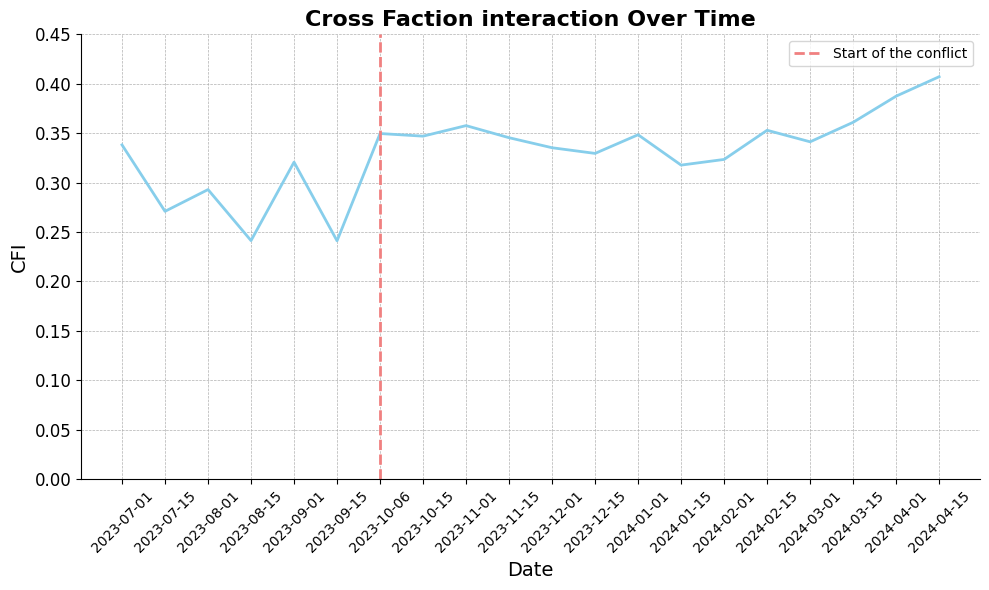

In [114]:

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(list_dates[:20], cross_factions, linestyle='-', color='skyblue', linewidth=2)  # Removed marker='o'


plt.title('Cross Faction interaction Over Time', fontsize=16, weight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('CFI', fontsize=14)
plt.axvline(x="2023-10-06", color='lightcoral', linestyle='--', linewidth=2, label='Start of the conflict')

plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=12)
plt.ylim(0, 0.45)  # Set the y-axis range from 0 to 0.45
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.tight_layout()
plt.legend()
plt.savefig("cfi.png")
plt.show()